In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from pathlib import Path

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json
import re

# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/asl-fingerspelling/supplemental_metadata.csv
/kaggle/input/asl-fingerspelling/character_to_prediction_index.json
/kaggle/input/asl-fingerspelling/train.csv
/kaggle/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2057261717.parquet
/kaggle/inpu

# 🔎 Dataset Description
El objetivo de esta competición es detectar y traducir el lenguaje de señas americano (ASL) a texto.

Esta competencia requiere que las presentaciones se realicen en forma de modelos de TensorFlow Lite. Puedes entrenar tu modelo utilizando el marco de trabajo de tu elección siempre que conviertas el punto de control del modelo al formato tflite antes de la presentación. Consulta la página de evaluación para obtener más detalles.

# 📄 Files

## [train/supplemental_metadata].csv

* `path` - La ruta al archivo de referencia.
* `file_id` - Un identificador único para el archivo de datos.
* `participant_id` - Un identificador único para el contribuyente de datos.
* `sequence_id` - Un identificador único para la secuencia de referencia. Cada archivo de datos puede contener muchas secuencias.
* `phrase` - Las etiquetas para la secuencia de referencia. Los conjuntos de datos de entrenamiento y prueba contienen **direcciones, números de teléfono y URL generados al azar, derivados de componentes de direcciones reales/números de teléfono/URL**. Cualquier coincidencia con direcciones reales, números de teléfono o URL es puramente accidental. **El conjunto de datos complementario consiste en oraciones deletreadas con los dedos**. Ten en cuenta que algunas de las URL incluyen contenido para adultos. El objetivo de esta competencia es apoyar a la comunidad de personas sordas y con discapacidad auditiva para que se involucren con la tecnología en igualdad de condiciones con otros adultos.

## character_to_prediction_index.json

Un diccionario en el que se asigna a distintos simbolos un número entero.

## [train/supplemental]_landmarks/

Los datos de referencia han sido extraídos con MediaPipe Holistic Solution, una herramienta de software que puede detectar y rastrear múltiples partes del cuerpo humano y gestos en secuencias de vídeo en tiempo real.

Los datos de referencia. Los puntos de referencia se extrajeron de videos en bruto con el modelo de MediaPipe. **No todos los fotogramas necesariamente tenían manos visibles o manos que pudieran ser detectadas por el modelo**.
Los archivos de referencia contienen los mismos datos que en la competición de ASL Signs (excepto la columna de ID de fila) pero con una estructura amplia. **Esto te permite aprovechar el formato Parquet para omitir por completo la carga de puntos de referencia que no estás utilizando**.

* `sequence_id` - Un identificador único para la secuencia de referencia. Los archivos de referencia contienen aproximadamente 1,000 secuencias. El ID de secuencia se utiliza como índice del dataframe.
* `frame` - El número de fotograma dentro de una secuencia de referencia.
* `[x/y/z]_[type]_[landmark_index]` - Ahora hay 1,629 columnas de coordenadas espaciales para las coordenadas x, y y z de cada uno de los 543 puntos de referencia. El tipo de punto de referencia puede ser uno de `['face', 'left_hand', 'pose', 'right_hand']`. Aquí se pueden encontrar detalles sobre las ubicaciones de los puntos de referencia de las manos. Las coordenadas espaciales ya han sido normalizadas por MediaPipe. Ten en cuenta que el modelo de MediaPipe no está completamente entrenado para predecir la profundidad, por lo que es posible que desees ignorar los valores de z. Los puntos de referencia se han convertido a float32.


## 1) Importamos los paquetes necesarios para llevar a cabo el anális exploratorio inicial de los datos:

In [2]:
# import the desired packages
import numpy as np
import pandas as pd
import json
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "simple_white"

Definimos las funciones que nos serán útiles para previsualizar los datos:

In [3]:
def map_new_to_old_style(sequence):
    """
    Esta funcíon recorre todas las columnas del DF (menos la de indice) y separa los distintos tipos de landmark.
    
    :sequence: DF donde cada fila representa un cierto instante de tiempo con MÚLTIPLES tipos de landmarks y sus coordenadas (x, y, z) correspondientes.
    :returns: Nuevo DF donde cada fila representa un cierto instante de tiempo con UN tipo de landmark específico y sus coordenadas (x, y, z) correspondientes.
    
    """
    types = []
    landmark_indexes = []
    for column in list(sequence.columns)[1:544]:
        parts = column.split("_")
        if len(parts) == 4:
            types.append(parts[1] + "_" + parts[2])
        else:
            types.append(parts[1])

        landmark_indexes.append(int(parts[-1]))

    data = {
        "frame": [],
        "type": [],
        "landmark_index": [],
        "x": [],
        "y": [],
        "z": []
    }

    for index, row in sequence.iterrows():
        data["frame"] += [int(row.frame)]*543
        data["type"] += types
        data["landmark_index"] += landmark_indexes

        for _type, landmark_index in zip(types, landmark_indexes):
            data["x"].append(row[f"x_{_type}_{landmark_index}"])
            data["y"].append(row[f"y_{_type}_{landmark_index}"])
            data["z"].append(row[f"z_{_type}_{landmark_index}"])

    return pd.DataFrame.from_dict(data)


# assign desired colors to landmarks
def assign_color(row):
    """
    No necesita explicación.
    """
    if row == 'face':
        return 'red'
    elif 'hand' in row:
        return 'dodgerblue'
    else:
        return 'green'


# specifies the plotting order
def assign_order(row):
    """
    No necesita explicación.
    """
    if row.type == 'face':
        return row.landmark_index + 101
    elif row.type == 'pose':
        return row.landmark_index + 30
    elif row.type == 'left_hand':
        return row.landmark_index + 80
    else:
        return row.landmark_index




def visualise2d_landmarks(parquet_df, title=""):
    """
    Función para visualizar los datos correspondientes a los landmarks creando un gráfico interactivo en 2D 
    con su variacion en el tiempo mediante Plotly.
    
    :parquet_df: Es el DataFrame que contiene los datos de cada landmarks por separado. Se asume que el DF ya ha pasado por la función 'map_new_to_old_style' para tener el formato correcto.
    :returns: Se muestran los datos utilizando fig.show(), lo que produce la visualización interactiva con la animación.
    """
    connections = [  
        [0, 1, 2, 3, 4,],
        [0, 5, 6, 7, 8],
        [0, 9, 10, 11, 12],
        [0, 13, 14, 15, 16],
        [0, 17, 18, 19, 20],

        
        [38, 36, 35, 34, 30, 31, 32, 33, 37],
        [40, 39],
        [52, 46, 50, 48, 46, 44, 42, 41, 43, 45, 47, 49, 45, 51],
        [42, 54, 56, 58, 60, 62, 58],
        [41, 53, 55, 57, 59, 61, 57],
        [54, 53],

        
        [80, 81, 82, 83, 84, ],
        [80, 85, 86, 87, 88],
        [80, 89, 90, 91, 92],
        [80, 93, 94, 95, 96],
        [80, 97, 98, 99, 100], ]

    parquet_df = map_new_to_old_style(parquet_df)
    frames = sorted(set(parquet_df.frame))
    first_frame = min(frames)
    parquet_df['color'] = parquet_df.type.apply(lambda row: assign_color(row))
    parquet_df['plot_order'] = parquet_df.apply(lambda row: assign_order(row), axis=1)
    first_frame_df = parquet_df[parquet_df.frame == first_frame].copy()
    first_frame_df = first_frame_df.sort_values(["plot_order"]).set_index('plot_order')


    frames_l = []
    for frame in frames:
        filtered_df = parquet_df[parquet_df.frame == frame].copy()
        filtered_df = filtered_df.sort_values(["plot_order"]).set_index("plot_order")
        traces = [go.Scatter(
            x=filtered_df['x'],
            y=filtered_df['y'],
            mode='markers',
            marker=dict(
                color=filtered_df.color,
                size=9))]

        for i, seg in enumerate(connections):
            trace = go.Scatter(
                    x=filtered_df.loc[seg]['x'],
                    y=filtered_df.loc[seg]['y'],
                    mode='lines',
            )
            traces.append(trace)
        frame_data = go.Frame(data=traces, traces = [i for i in range(17)])
        frames_l.append(frame_data)

    traces = [go.Scatter(
        x=first_frame_df['x'],
        y=first_frame_df['y'],
        mode='markers',
        marker=dict(
            color=first_frame_df.color,
            size=9
        )
    )]
    for i, seg in enumerate(connections):
        trace = go.Scatter(
            x=first_frame_df.loc[seg]['x'],
            y=first_frame_df.loc[seg]['y'],
            mode='lines',
            line=dict(
                color='black',
                width=2
            )
        )
        traces.append(trace)
    fig = go.Figure(
        data=traces,
        frames=frames_l
    )


    fig.update_layout(
        width=500,
        height=800,
        scene={
            'aspectmode': 'data',
        },
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [None, {"frame": {"duration": 100,
                                                  "redraw": True},
                                        "fromcurrent": True,
                                        "transition": {"duration": 0}}],
                        "label": "&#9654;",
                        "method": "animate",
                    },

                ],
                "direction": "left",
                "pad": {"r": 100, "t": 100},
                "font": {"size":30},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
        ],
    )
    camera = dict(
        up=dict(x=0, y=-1, z=0),
        eye=dict(x=0, y=0, z=2.5)
    )
    fig.update_layout(title_text=title, title_x=0.5)
    fig.update_layout(scene_camera=camera, showlegend=False)
    fig.update_layout(xaxis = dict(visible=False),
            yaxis = dict(visible=False),
    )
    fig.update_yaxes(autorange="reversed")

    fig.show()


def get_phrase(df, file_id, sequence_id):
    """
    Obtiene la frase asociada a un file_id y un sequence_id específicos.
    
    :df: EL DF donde están contenidos los datos.
    :file_id: Aqrchivo especifico de donde se va a seleccionar la frase.
    :sequence_id: Secuencia específica dentro del archivo seleccionado.
    """
    return df[
        np.logical_and(
            df.file_id == file_id, 
            df.sequence_id == sequence_id
        )
    ].phrase.iloc[0]

## 2 ) EDA del conjunto de entrenamiento:

Cargamos y previsualizamos los datos:

In [4]:
train_df = pd.read_csv("/kaggle/input/asl-fingerspelling/train.csv")

train_df.head()

path  file_id  sequence_id  participant_id  \
0  train_landmarks/5414471.parquet  5414471   1816796431             217   
1  train_landmarks/5414471.parquet  5414471   1816825349             107   
2  train_landmarks/5414471.parquet  5414471   1816909464               1   
3  train_landmarks/5414471.parquet  5414471   1816967051              63   
4  train_landmarks/5414471.parquet  5414471   1817123330              89   

                      phrase  
0               3 creekhouse  
1            scales/kuhaylah  
2        1383 william lanier  
3          988 franklin lane  
4  6920 northeast 661st road

In [5]:
train_df.file_id

0           5414471
1           5414471
2           5414471
3           5414471
4           5414471
            ...    
67203    2118949241
67204    2118949241
67205    2118949241
67206    2118949241
67207    2118949241
Name: file_id, Length: 67208, dtype: int64

Analizamos de manera preliminar un descriptivo básico del tipo de datos presente en el dataset: 

In [6]:
train_df.describe()

file_id   sequence_id  participant_id
count  6.720800e+04  6.720800e+04    67208.000000
mean   1.094448e+09  1.072696e+09      119.758154
std    6.395616e+08  6.177372e+08       74.330468
min    5.414471e+06  7.109500e+04        0.000000
25%    5.277082e+08  5.376519e+08       63.000000
50%    1.099408e+09  1.074387e+09      113.000000
75%    1.662743e+09  1.605592e+09      178.000000
max    2.118949e+09  2.147465e+09      254.000000

Vamos a tratar de visualizar una de las secuencias de referencia presentes en el dataset. Como un archivo 'file_id' contiene diferentes secuencias de referencia, seleccionaremos la misma por el 'sequence_id'. Del mismo modo, para cada secuencia vamos a tener un número variable de fotogramas. 

In [7]:
train_df[train_df.file_id==2118949241]. head(25)

path     file_id  sequence_id  \
66210  train_landmarks/2118949241.parquet  2118949241    355793591   
66211  train_landmarks/2118949241.parquet  2118949241    355829646   
66212  train_landmarks/2118949241.parquet  2118949241    355838534   
66213  train_landmarks/2118949241.parquet  2118949241    355954522   
66214  train_landmarks/2118949241.parquet  2118949241    355954653   
66215  train_landmarks/2118949241.parquet  2118949241    355965568   
66216  train_landmarks/2118949241.parquet  2118949241    355983883   
66217  train_landmarks/2118949241.parquet  2118949241    355993778   
66218  train_landmarks/2118949241.parquet  2118949241    356104201   
66219  train_landmarks/2118949241.parquet  2118949241    356248166   
66220  train_landmarks/2118949241.parquet  2118949241    356250008   
66221  train_landmarks/2118949241.parquet  2118949241    356250546   
66222  train_landmarks/2118949241.parquet  2118949241    356255371   
66223  train_landmarks/2118949241.parquet  2118949241    356307033   
66224  train_landmarks/2118949241.parquet  2118949241    356329396   
66225  train_landmarks/2118949241.parquet  2118949241    356334239   
66226  train_landmarks/2118949241.parquet  2118949241    356347764   
66227  train_landmarks/2118949241.parquet  2118949241    356397046   
66228  train_landmarks/2118949241.parquet  2118949241    356423810   
66229  train_landmarks/2118949241.parquet  2118949241    356455232   
66230  train_landmarks/2118949241.parquet  2118949241    356458321   
66231  train_landmarks/2118949241.parquet  2118949241    356478050   
66232  train_landmarks/2118949241.parquet  2118949241    356524638   
66233  train_landmarks/2118949241.parquet  2118949241    356526389   
66234  train_landmarks/2118949241.parquet  2118949241    356531167   

       participant_id                         phrase  
66210              68                     patrimonio  
66211             176            +61-334-519-549-258  
66212             188     www.arte.tv/yogurt-mix-ins  
66213             138           floragreatlakes.info  
66214               6                7126 e 156th st  
66215              15                   nikki rogers  
66216             158             chicureo.com/06212  
66217             154     148 east middle river road  
66218              74                      5654 1704  
66219             186   electricalengineeringmcq.com  
66220              74                  jennie george  
66221             225   www.hairassist-muu.com/kells  
66222             153                9568 11th north  
66223             216             9802 salsburg road  
66224              89                   471-791-7380  
66225             141          www.yasudaatelier.com  
66226             136         +44-511-81-62-0467-780  
66227             231     9473 northwest 105th court  
66228              38         5319 usfs road 9521191  
66229             154  nolnet.edu.na/beowulf_cluster  
66230             112   www.az-portugal.com/s-select  
66231             115               1012 cove harbor  
66232             188             lakesha cunningham  
66233             105             www.oggitreviso.it  
66234             136                  byron marquez

In [8]:
# Seleccionamos el archivo y lo cargamos usando su ruta de referencia (los archivos estan en formato parquet):
file_id = 2118949241
path_to_sign = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"

# Leemos el archivo parquet:
sign = pd.read_parquet(path_to_sign)

In [9]:
sign.head(15)

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
355793591        0  0.499324  0.484331  0.491583  0.474111  0.482560   
355793591        1  0.498195  0.485005  0.492149  0.474162  0.483109   
355793591        2  0.497304  0.484793  0.491891  0.474097  0.482950   
355793591        3  0.497009  0.484610  0.491679  0.474002  0.482792   
355793591        4  0.497113  0.484813  0.491821  0.474145  0.482997   
355793591        5  0.496276  0.484955  0.491795  0.474170  0.483154   
355793591        6  0.495779  0.483344  0.490445  0.472744  0.481507   
355793591        7  0.496774  0.482686  0.490070  0.472404  0.480917   
355793591        8  0.496580  0.483822  0.491253  0.473244  0.481916   
355793591        9  0.497545  0.483282  0.490566  0.473023  0.481510   
355793591       10  0.497537  0.483480  0.490689  0.473184  0.481732   
355793591       11  0.497400  0.482952  0.490404  0.472627  0.481134   
355793591       12  0.496543  0.483247  0.490766  0.472935  0.481430   
355793591       13  0.497858  0.483660  0.491089  0.473328  0.481871   
355793591       14  0.498546  0.483019  0.490456  0.472861  0.481259   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
355793591    0.483250  0.487669  0.406235  0.487851  ...        -0.203911   
355793591    0.483531  0.487266  0.406365  0.487151  ...              NaN   
355793591    0.483447  0.487316  0.405166  0.487316  ...              NaN   
355793591    0.483324  0.487352  0.405585  0.487387  ...              NaN   
355793591    0.483498  0.487425  0.405697  0.487456  ...              NaN   
355793591    0.483616  0.487420  0.405922  0.487438  ...              NaN   
355793591    0.482098  0.486192  0.405244  0.486261  ...              NaN   
355793591    0.481635  0.485976  0.404947  0.486127  ...        -0.205465   
355793591    0.482471  0.486563  0.405740  0.486532  ...              NaN   
355793591    0.482212  0.486664  0.405716  0.486994  ...        -0.155702   
355793591    0.482413  0.486796  0.405297  0.487139  ...              NaN   
355793591    0.481777  0.486110  0.405527  0.486323  ...              NaN   
355793591    0.482068  0.486406  0.405702  0.486595  ...              NaN   
355793591    0.482541  0.486932  0.406026  0.487162  ...              NaN   
355793591    0.482004  0.486599  0.406027  0.486972  ...              NaN   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
355793591          -0.224760        -0.091991        -0.195761   
355793591                NaN              NaN              NaN   
355793591                NaN              NaN              NaN   
355793591                NaN              NaN              NaN   
355793591                NaN              NaN              NaN   
355793591                NaN              NaN              NaN   
355793591                NaN              NaN              NaN   
355793591          -0.224196        -0.111388        -0.222720   
355793591                NaN              NaN              NaN   
355793591          -0.157063        -0.057845        -0.137262   
355793591                NaN              NaN              NaN   
355793591                NaN              NaN              NaN   
355793591                NaN              NaN              NaN   
355793591                NaN              NaN              NaN   
355793591                NaN              NaN              NaN   

             z_right_hand_15  z_right_hand_16  z_right_hand_17  \
sequence_id                                                      
355793591          -0.212482        -0.194469        -0.113776   
355793591                NaN              NaN              NaN   
355793591                NaN              NaN              NaN   
355793591                

In [10]:
print('Número de secuencias de referencia en el archivo file_id=', file_id,':\n', len(np.unique(sign.index)))

Número de secuencias de referencia en el archivo file_id= 2118949241 :
 998


Comprobamos que cada archivo 'file_id' contiene aproximadamente unas 1000 secuencias de referencia. Vamos a seleccionar una de ellas por el 'sequence_id':

In [11]:
sequence_id= 355993778
sequence = sign[sign.index == sequence_id]
sequence.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
355993778        0  0.434897  0.438510  0.435448  0.421250  0.438887   
355993778        1  0.433828  0.441007  0.437459  0.422807  0.441146   
355993778        2  0.429798  0.438546  0.434826  0.422102  0.439175   
355993778        3  0.430158  0.437597  0.433918  0.421202  0.438188   
355993778        4  0.429337  0.435288  0.431833  0.418755  0.435837   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
355993778    0.437999  0.434173  0.311037  0.432501  ...              NaN   
355993778    0.439695  0.434431  0.310698  0.432143  ...              NaN   
355993778    0.438398  0.434946  0.311828  0.433961  ...              NaN   
355993778    0.437394  0.433894  0.313520  0.432739  ...              NaN   
355993778    0.435083  0.431700  0.308095  0.430593  ...              NaN   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
355993778                NaN              NaN              NaN   
355993778                NaN              NaN              NaN   
355993778                NaN              NaN              NaN   
355993778                NaN              NaN              NaN   
355993778                NaN              NaN              NaN   

             z_right_hand_15  z_right_hand_16  z_right_hand_17  \
sequence_id                                                      
355993778                NaN              NaN              NaN   
355993778                NaN              NaN              NaN   
355993778                NaN              NaN              NaN   
355993778                NaN              NaN              NaN   
355993778                NaN              NaN              NaN   

             z_right_hand_18  z_right_hand_19  z_right_hand_20  
sequence_id                                                     
355993778                NaN              NaN              NaN  
355993778                NaN              NaN              NaN  
355993778                NaN              NaN              NaN  
355993778                NaN              NaN              NaN  
355993778                NaN              NaN              NaN  

[5 rows x 1630 columns]

Visualizamos la frase correspondiente a la secuencia seleccionada:

In [12]:
sequence_phrase = get_phrase(train_df, file_id, sequence_id)
visualise2d_landmarks(sequence, f"Phrase: {sequence_phrase}")

In [13]:
#import matplotlib.pyplot as plt

# ¿Y si quisiérmaos visualizar el número de Nans por secuencia? para saber más o menos la proporción de valores faltantes,
#lo que nos daría un indicador de si las manos (u otros landmarks) están visibles o no en la secuencia:

#nan_count_por_secuencia = sign.isnull().sum(axis=1)

# Graficamos:
#plt.figure(figsize=(10, 6))
#plt.bar(nan_count_por_secuencia.index, nan_count_por_secuencia.values)
#plt.xlabel('Secuencia')
#plt.ylabel('Cantidad de NaNs')
#plt.title('Número de NaNs por secuencia')
#plt.show()

#TARDA MUCHO EN PLOTEAR Y SERÍA PARA UN SOLO ARCHIVO, ESTUDIAR MÁS EN PROFUNDIDAD.


_________
__________
## Otras ideas de EDA de cara al preprocesamiento:

______
______

### Data Preparation:

In [22]:
#DEBUG: Esta variable indica si se está ejecutando en modo de depuración. Si es True, se ejecutará en modo de depuración, lo que puede implicar 
#la ejecución de un subconjunto de los datos para una ejecución más rápida y para facilitar la depuración.

DEBUG = False

# Read Train DataFrame
if DEBUG:
    train_df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
else:
    train_df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')

# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'

train_df['file_path'] = train_df['path'].apply(get_file_path)

train_df.head()

path  file_id  sequence_id  participant_id  \
0  train_landmarks/5414471.parquet  5414471   1816796431             217   
1  train_landmarks/5414471.parquet  5414471   1816825349             107   
2  train_landmarks/5414471.parquet  5414471   1816909464               1   
3  train_landmarks/5414471.parquet  5414471   1816967051              63   
4  train_landmarks/5414471.parquet  5414471   1817123330              89   

                      phrase  \
0               3 creekhouse   
1            scales/kuhaylah   
2        1383 william lanier   
3          988 franklin lane   
4  6920 northeast 661st road   

                                           file_path  
0  /kaggle/input/asl-fingerspelling/train_landmar...  
1  /kaggle/input/asl-fingerspelling/train_landmar...  
2  /kaggle/input/asl-fingerspelling/train_landmar...  
3  /kaggle/input/asl-fingerspelling/train_landmar...  
4  /kaggle/input/asl-fingerspelling/train_landmar...

Definimos la función `get_phrase_type`, que toma como entrada una frase (phrase):

- Primero, verifica si la frase consiste únicamente en dígitos, signos de más (+) o guiones (-) utilizando la expresión regex `re.match(r'^[\d+-]+$', phrase)`. Si la frase cumple con este patrón, se considera un "Phone Number" (número de teléfono).
- Si no se cumple la primera condición, la función verifica si la frase contiene alguna de las subcadenas `['www', '.', '/']` y no contiene espacios en blanco mediante la expresión `any([substr in phrase for substr in ['www', '.', '/']])` and `' ' not in phrase`. Si se cumple esta condición, se considera una "URL".
- Si ninguna de las dos condiciones anteriores se cumple, se asume que la frase es una "Address" (dirección).
- Finalmente, la función devuelve el indetificativo

In [23]:
def get_phrase_type(phrase):
    # Phone Number
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    # url
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    # Address
    else:
        return 'address'
    
train_df['phrase_type'] = train_df['phrase'].apply(get_phrase_type)

train_df.head(10)

path  file_id  sequence_id  participant_id  \
0  train_landmarks/5414471.parquet  5414471   1816796431             217   
1  train_landmarks/5414471.parquet  5414471   1816825349             107   
2  train_landmarks/5414471.parquet  5414471   1816909464               1   
3  train_landmarks/5414471.parquet  5414471   1816967051              63   
4  train_landmarks/5414471.parquet  5414471   1817123330              89   
5  train_landmarks/5414471.parquet  5414471   1817141095              38   
6  train_landmarks/5414471.parquet  5414471   1817169529              70   
7  train_landmarks/5414471.parquet  5414471   1817171518             202   
8  train_landmarks/5414471.parquet  5414471   1817195757             136   
9  train_landmarks/5414471.parquet  5414471   1817216847              93   

                      phrase  \
0               3 creekhouse   
1            scales/kuhaylah   
2        1383 william lanier   
3          988 franklin lane   
4  6920 northeast 661st road   
5            www.freem.ne.jp   
6     https://jsi.is/hukuoka   
7       239613 stolze street   
8               242-197-6202   
9  271097 bayshore boulevard   

                                           file_path   phrase_type  
0  /kaggle/input/asl-fingerspelling/train_landmar...       address  
1  /kaggle/input/asl-fingerspelling/train_landmar...           url  
2  /kaggle/input/asl-fingerspelling/train_landmar...       address  
3  /kaggle/input/asl-fingerspelling/train_landmar...       address  
4  /kaggle/input/asl-fingerspelling/train_landmar...       address  
5  /kaggle/input/asl-fingerspelling/train_landmar...           url  
6  /kaggle/input/asl-fingerspelling/train_landmar...           url  
7  /kaggle/input/asl-fingerspelling/train_landmar...       address  
8  /kaggle/input/asl-fingerspelling/train_landmar...  phone_number  
9  /kaggle/input/asl-fingerspelling/train_landmar...       address

<Figure size 1000x200 with 0 Axes>

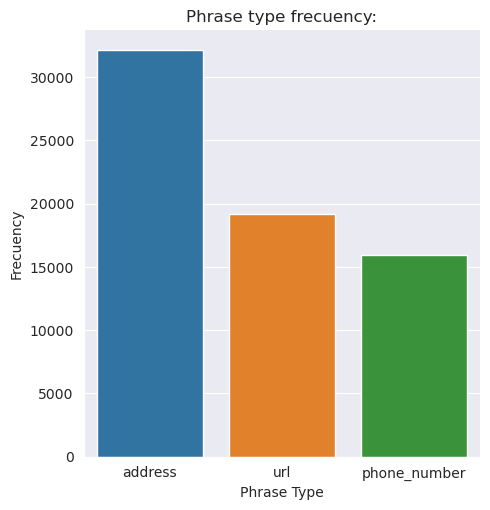

In [24]:
# Phrase type plot:
plt.figure(figsize=(10,2))

sns.catplot(x="phrase_type", y=None, kind="count", data=train_df)
plt.xlabel('Phrase Type')
plt.ylabel('Frecuency')
plt.title('Phrase type frecuency:')


plt.show()

#### 1) Análisis de secuencias: 

Hemos visto que cada archivo de datos contiene aproximadamente unas 1000 secuencias de referencia cada uno. Si analizamos dichas secuencias se ha comprobado que cada una representa frases de distintas características y naturaleza con un determinado número de caracteres. Del mismo modo se ha observado también que cada secuencia está compuesta por un número diferente de frames, siendo por tanto unas más largas que otras. 

Por esta razón, se llevará un análisis de las secuendcias atendiendo por un lado alnúmero de caracteres que contiene la frase que representan y por otro, al número de frames necesarios para representarlas.

**1.1) Análisis de los caracteres y longitud de la frase contenida en cada secuencia:**

Extraemos de la frase los caracteres y la longitud de la frase.

In [25]:
# Split Phrase To Char Tuple
train_df['phrase_char'] = train_df['phrase'].apply(tuple)
# Character Length of Phrase
train_df['phrase_char_len'] = train_df['phrase_char'].apply(len)

# Maximum Input Length
MAX_PHRASE_LENGTH = train_df['phrase_char_len'].max()
print(f'MAX_PHRASE_LENGTH: {MAX_PHRASE_LENGTH}')

# Train DataFrame indexed by sequence_id to convenientlyy lookup recording data
train_sequence_id = train_df.set_index('sequence_id')

train_df.head()

MAX_PHRASE_LENGTH: 31


path  file_id  sequence_id  participant_id  \
0  train_landmarks/5414471.parquet  5414471   1816796431             217   
1  train_landmarks/5414471.parquet  5414471   1816825349             107   
2  train_landmarks/5414471.parquet  5414471   1816909464               1   
3  train_landmarks/5414471.parquet  5414471   1816967051              63   
4  train_landmarks/5414471.parquet  5414471   1817123330              89   

                      phrase  \
0               3 creekhouse   
1            scales/kuhaylah   
2        1383 william lanier   
3          988 franklin lane   
4  6920 northeast 661st road   

                                           file_path phrase_type  \
0  /kaggle/input/asl-fingerspelling/train_landmar...     address   
1  /kaggle/input/asl-fingerspelling/train_landmar...         url   
2  /kaggle/input/asl-fingerspelling/train_landmar...     address   
3  /kaggle/input/asl-fingerspelling/train_landmar...     address   
4  /kaggle/input/asl-fingerspelling/train_landmar...     address   

                                         phrase_char  phrase_char_len  
0               (3,  , c, r, e, e, k, h, o, u, s, e)               12  
1      (s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)               15  
2  (1, 3, 8, 3,  , w, i, l, l, i, a, m,  , l, a, ...               19  
3  (9, 8, 8,  , f, r, a, n, k, l, i, n,  , l, a, ...               17  
4  (6, 9, 2, 0,  , n, o, r, t, h, e, a, s, t,  , ...               25

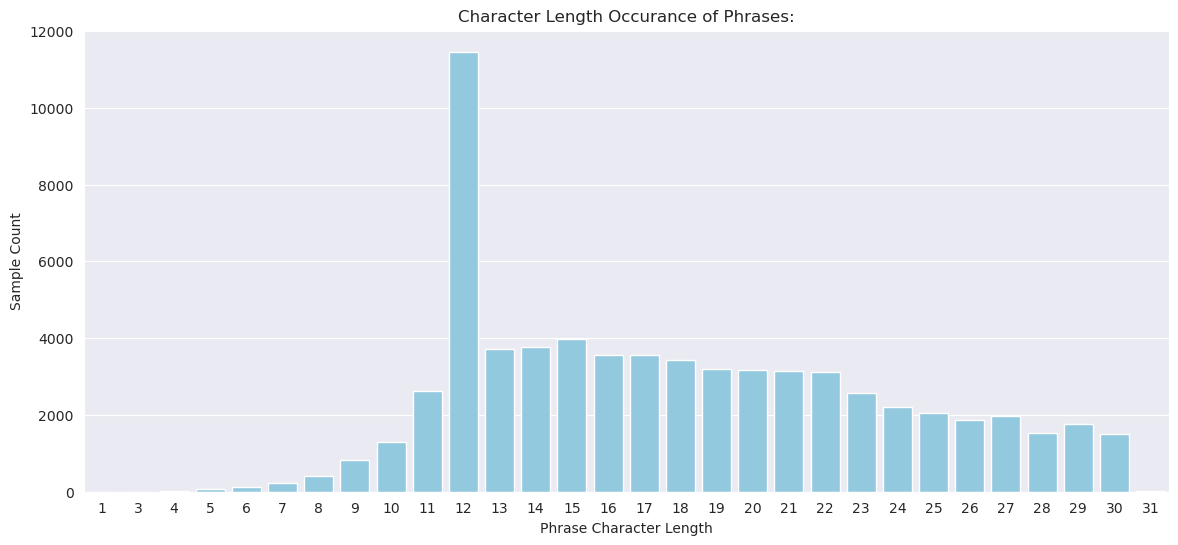

In [26]:
# Character Count Occurance
plt.figure(figsize=(14,6))

sns.countplot(data=train_df, x='phrase_char_len', color='skyblue')
plt.xlabel('Phrase Character Length')
plt.ylabel('Sample Count')
plt.title('Character Length Occurance of Phrases:')

plt.show()

**1.2) Análisis del número de frames contenidos por secuencia:**

Dado que cada archivo puede contener muchas secuencias de landmark, vamos a visualizar la distribución de la cantidad de fotogramas en cada secuencia para entender su variabilidad y posiblemente detectar secuencias atípicas o muy cortas/largas.

Para ello:

- Define una variable `N` que indica el número de fragmentos de archivos Parquet que se analizarán. Si la variable IS_INTERACTIVE es True, se establece N en 5, de lo contrario, se establece en 25.
- Define una lista vacía `N_UNIQUE_FRAMES` que se utilizará para almacenar el número de frames únicos en cada grabación. 
- Crea una serie `UNIQUE_FILE_PATHS` que contiene las rutas únicas de los archivos del DataFrame train en la columna "file_path".
- Luego, se itera sobre una muestra aleatoria de N rutas de archivos obtenidas de UNIQUE_FILE_PATHS utilizando UNIQUE_FILE_PATHS.sample(N, random_state=SEED). Esto implica seleccionar aleatoriamente un subconjunto de rutas de archivo para analizar.
- Para cada ruta de archivo seleccionada, se lee el archivo Parquet correspondiente utilizando pd.read_parquet(file_path) y se almacena en el DataFrame df. A continuación, el DataFrame df se agrupa por el valor de la columna "sequence_id" utilizando groupby('sequence_id').
- Para cada grupo (grupo de secuencias con el mismo ID), se calcula el número de cuadros únicos en la columna "frame" utilizando group_df['frame'].nunique().El número de cuadros únicos obtenidos se agrega a la lista N_UNIQUE_FRAMES.

In [27]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
# Global Random Seed
SEED = 42

# Number of parquet chunks to analyse
N = 5 if IS_INTERACTIVE else 25
# Number of Unique Frames in Recording
N_UNIQUE_FRAMES = []

UNIQUE_FILE_PATHS = pd.Series(train_df['file_path'].unique()) # total file paths

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path) # read the parquet 
    for group, group_df in df.groupby('sequence_id'):
        N_UNIQUE_FRAMES.append(group_df['frame'].nunique())

# Convert to Numpy Array
N_UNIQUE_FRAMES = np.array(N_UNIQUE_FRAMES)

  0%|          | 0/25 [00:00<?, ?it/s]

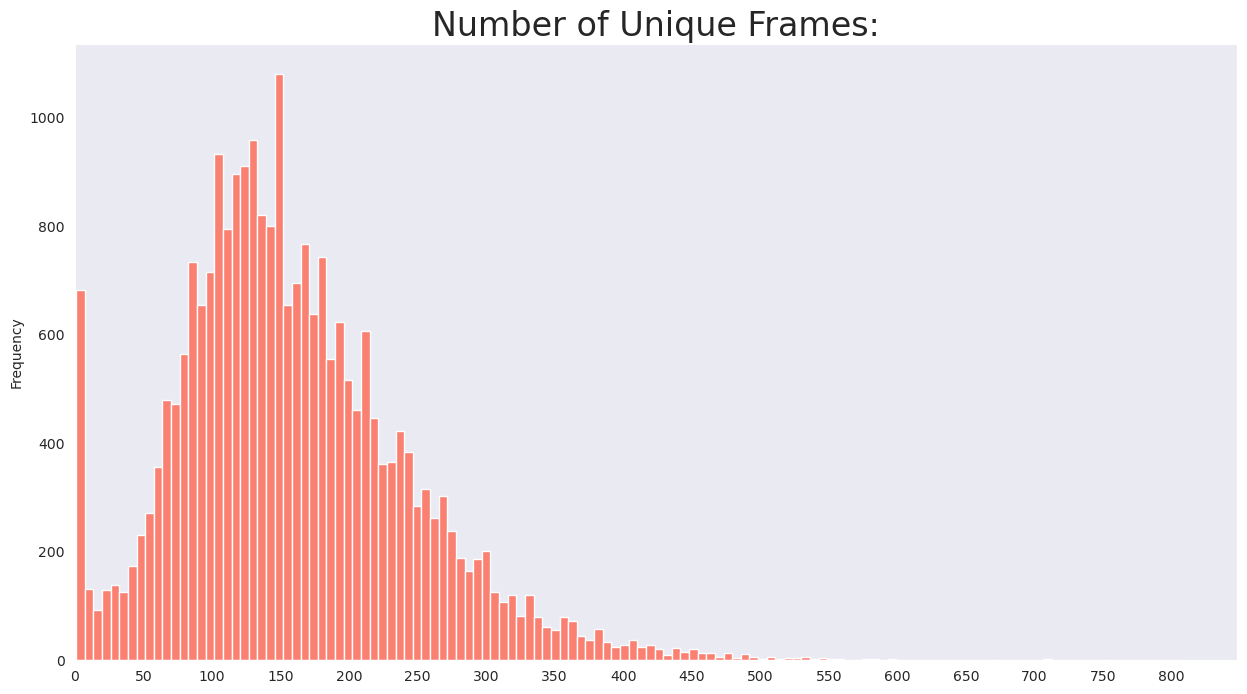

In [28]:
plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames:', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128, color= 'salmon')

xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim, 50))
plt.grid()
plt.show()